In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix , accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import pandas as pan
import matplotlib.pyplot as plotter
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Create train Files_Name
image_data='/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset'
train_files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(train_files)
train_labels = [os.path.dirname(i).split("/")[-1] for i in train_files]
train_data = zip(train_files, train_labels)
train_df = pd.DataFrame(train_data, columns=["Image", "Label"])
train_df

,Image,Label
0,/kaggle/input/chest-x-ray-dataset-4-categories...,NORMAL
1,/kaggle/input/chest-x-ray-dataset-4-categories...,NORMAL
2,/kaggle/input/chest-x-ray-dataset-4-categories...,PNEUMONIA
3,/kaggle/input/chest-x-ray-dataset-4-categories...,NORMAL
4,/kaggle/input/chest-x-ray-dataset-4-categories...,NORMAL
...,...,...
7127,/kaggle/input/chest-x-ray-dataset-4-categories...,PNEUMONIA
7128,/kaggle/input/chest-x-ray-dataset-4-categories...,PNEUMONIA
7129,/kaggle/input/chest-x-ray-dataset-4-categories...,PNEUMONIA
7130,/kaggle/input/chest-x-ray-dataset-4-categories...,NORMAL


Label
PNEUMONIA        59.913068
NORMAL           22.195738
TURBERCULOSIS     9.814919
COVID19           8.076276
Name: proportion, dtype: float64


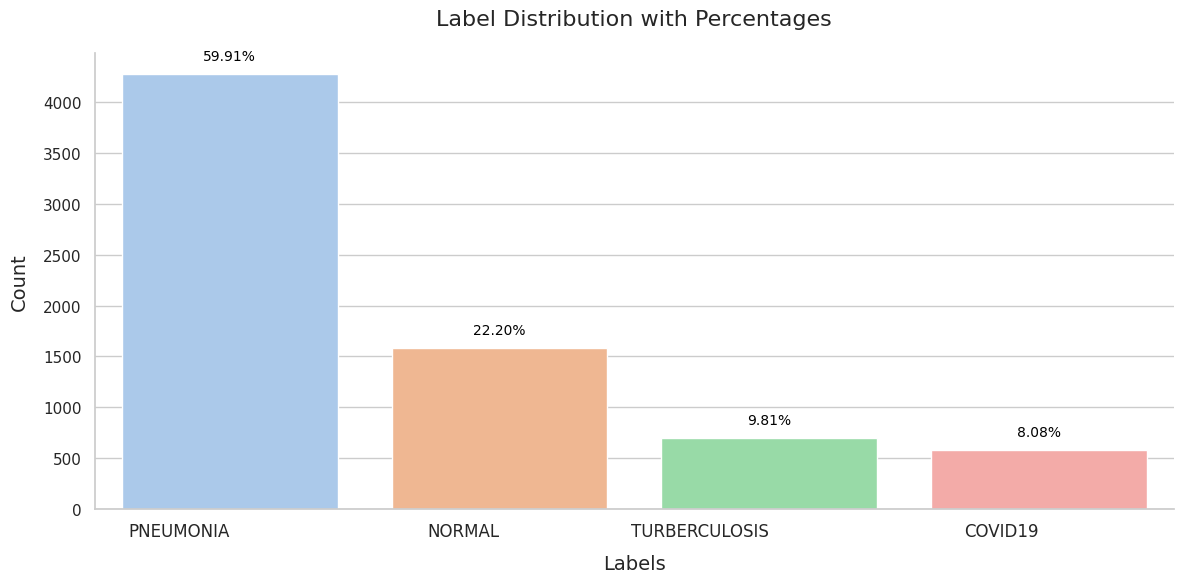

In [3]:
# Set a theme for better aesthetics
sns.set_theme(style="whitegrid")

# Calculate counts and percentages for each label
count_data = train_df["Label"].value_counts()
percentage_data = train_df["Label"].value_counts(normalize=True) * 100  # Calculate percentage

# Print percentage for each label (optional)
print(percentage_data)

# Sort the labels based on count values in descending order
sorted_data = count_data.sort_values(ascending=False).index

# Create a color palette for the bars
palette = sns.color_palette("pastel", len(sorted_data))

# Plot the count plot with sorted labels
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=train_df["Label"], order=sorted_data, palette=palette)

# Annotate each bar with the percentage value
for p in ax.patches:
    height = p.get_height()  # Get the height of the bar
    percentage = f'{(height / count_data.sum()) * 100:.2f}%'  # Calculate percentage
    ax.annotate(percentage,  # The label to be annotated
                (p.get_x() + p.get_width() / 2., height),  # Position of the label
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 8), textcoords='offset points')

# Rotate x-axis labels for better visibility and set the label font size
plt.xticks(rotation=0, ha='right', fontsize=12)

# Add title and labels with improved fonts and padding
plt.title("Label Distribution with Percentages", fontsize=16, pad=20)
plt.xlabel("Labels", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Preprocessing

keras.preprocessing

directory : Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class. Otherwise, the directory structure is ignored.

batch_size : Size of the batches of data. If None, the data will not be batched (the dataset will yield individual samples). Defaults to 32.

image_size : Size to resize images to after they are read from disk, specified as (height, width). Since the pipeline processes batches of images that must all have the same size, this must be provided.

seed : Optional random seed for shuffling and transformations.

validation_split : Optional float between 0 and 1, fraction of data to reserve for validation.

subset : Subset of the data to return. One of "training", "validation", or "both". Only used if validation_split is set. When subset="both", the utility returns a tuple of two datasets (the training and validation datasets respectively).


#### Split the data into train, validation, and test sets

Found 7132 files belonging to 4 classes.
Using 5349 files for training.
Found 7132 files belonging to 4 classes.
Using 1783 files for validation.
Training samples: 669, Validation samples: 111, Test samples: 112


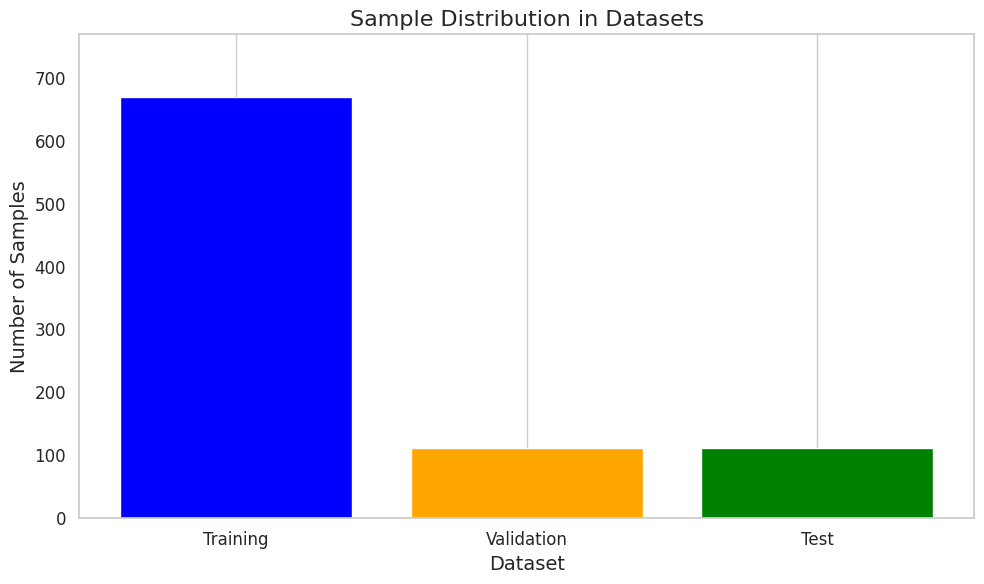

In [4]:
# Set up variables
train_data_dir = image_data
batch_size = 8
target_size = (224, 224)
validation_split = 0.25  # Total split for validation + test
seed = 100

# Generate training + validation dataset
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=target_size,
    batch_size=batch_size,
)

# Generate validation + test dataset
val_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=target_size,
    batch_size=batch_size,
)

# Calculate test dataset size (assuming a split of 80% train, 10% validation, and 10% test)
val_size = math.floor(len(val_test_dataset) * 0.5)
test_size = len(val_test_dataset) - val_size

# Further split into validation and test datasets
validation = val_test_dataset.take(val_size)
test = val_test_dataset.skip(val_size)

# Check the sample count for each dataset
print(f"Training samples: {len(train)}, Validation samples: {val_size}, Test samples: {test_size}")

# Sample counts for each dataset
train_samples = len(train)
val_samples = val_size
test_samples = test_size

# Names for the datasets
datasets = ['Training', 'Validation', 'Test']
sample_counts = [train_samples, val_samples, test_samples]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(datasets, sample_counts, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Sample Distribution in Datasets', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(sample_counts) + 100)  
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

Split 75% for training, 12.5% for validation, and 12.5% for test.

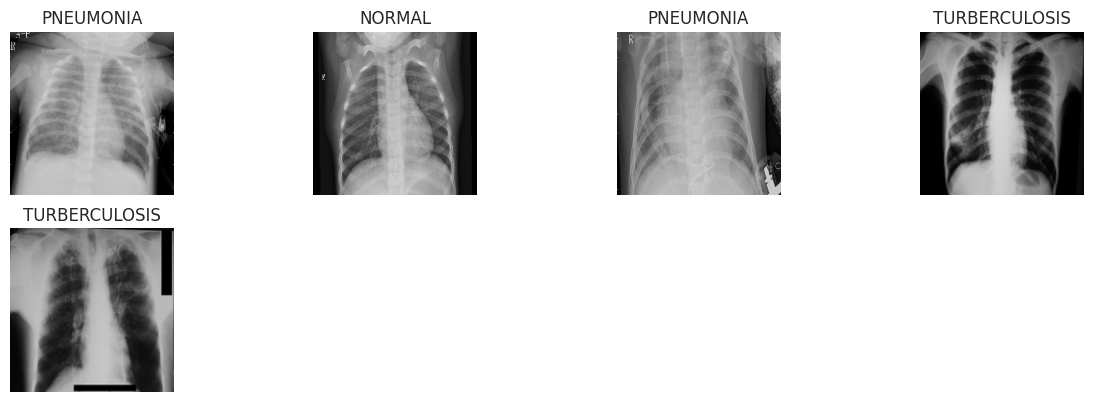

In [5]:
class_names = train.class_names

plt.figure(figsize=(15, 20))
num_images_per_class = 2 
count = {class_name: 0 for class_name in class_names}  

for images, labels in train.take(1):
    for i in range(len(labels)):
        label = class_names[labels[i]]
        if count[label] < num_images_per_class:  
            ax = plt.subplot(8, 4, sum(count.values()) + 1)  
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(label)
            plt.axis("off")
            count[label] += 1  
        if sum(count.values()) >= num_images_per_class * len(class_names):
            break  #

### Credit:


https://www.kaggle.com/code/guanlintao/acc-98-convnexttiny-chest-x-ray/notebook